In [107]:
import ROOT
import numpy as np
import array
from tqdm import tqdm
import copy
ROOT.gStyle.SetOptStat(0)

In [112]:
def get_rdataframe(pion_pair,version):
    if version == "data":
        if pion_pair == [211,111]:
            filesuffix = "Fall2018_RGA_inbending_merged_cuts.root"
            #filesuffix = "nSidis_RGA_5036.root"
        elif pion_pair == [-211,111]:
            filesuffix = "Spring2019_RGA_outbending_merged_cuts.root"
    elif version == "MC":
        if pion_pair == [211,111]:
            filesuffix = "MC_RGA_inbending_merged_cuts.root"
            #filesuffix = "MC_RGA_3051_0.root"
        elif pion_pair == [-211,111]:
            filesuffix = "MC_RGA_outbending_merged_cuts.root"

    pid_str_1 = str(pion_pair[0]).replace("-211","piminus").replace("211","piplus").replace("111","pi0")
    pid_str_2 = str(pion_pair[1]).replace("-211","piminus").replace("211","piplus").replace("111","pi0")
    
    

    
    dihadron_str = f"{pid_str_1}_{pid_str_2}"
    file = f"/volatile/clas12/users/gmat/clas12analysis.sidis.data/clas12_dihadrons/projects/pipi0_paper_RGA_only/data/{dihadron_str}/{filesuffix}"
    tree = "dihadron_cuts"
    
    tfile = ROOT.TFile(file)
    ttree = tfile.Get(tree)
    
    if version=="data":
        global nentries_data
        nentries_data = ttree.GetEntries()
    elif version=="MC":
        global nentries_mc
        nentries_mc = ttree.GetEntries()
    
    
    
    return ROOT.RDataFrame(tree,file)

In [109]:
pion_pair=[211,111]
tfile_data,tdata = get_tfile_ttree(pion_pair,"data")
tfile_mc,tmc = get_tfile_ttree(pion_pair,"MC")

nentries_data = tdata.GetEntries()
nentries_mc = tmc.GetEntries()

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 70.56it/s]
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TFile::Append>: Replacing existing TH1: hist_data_4_4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hist_mc_4_4 (Potential memory leak).


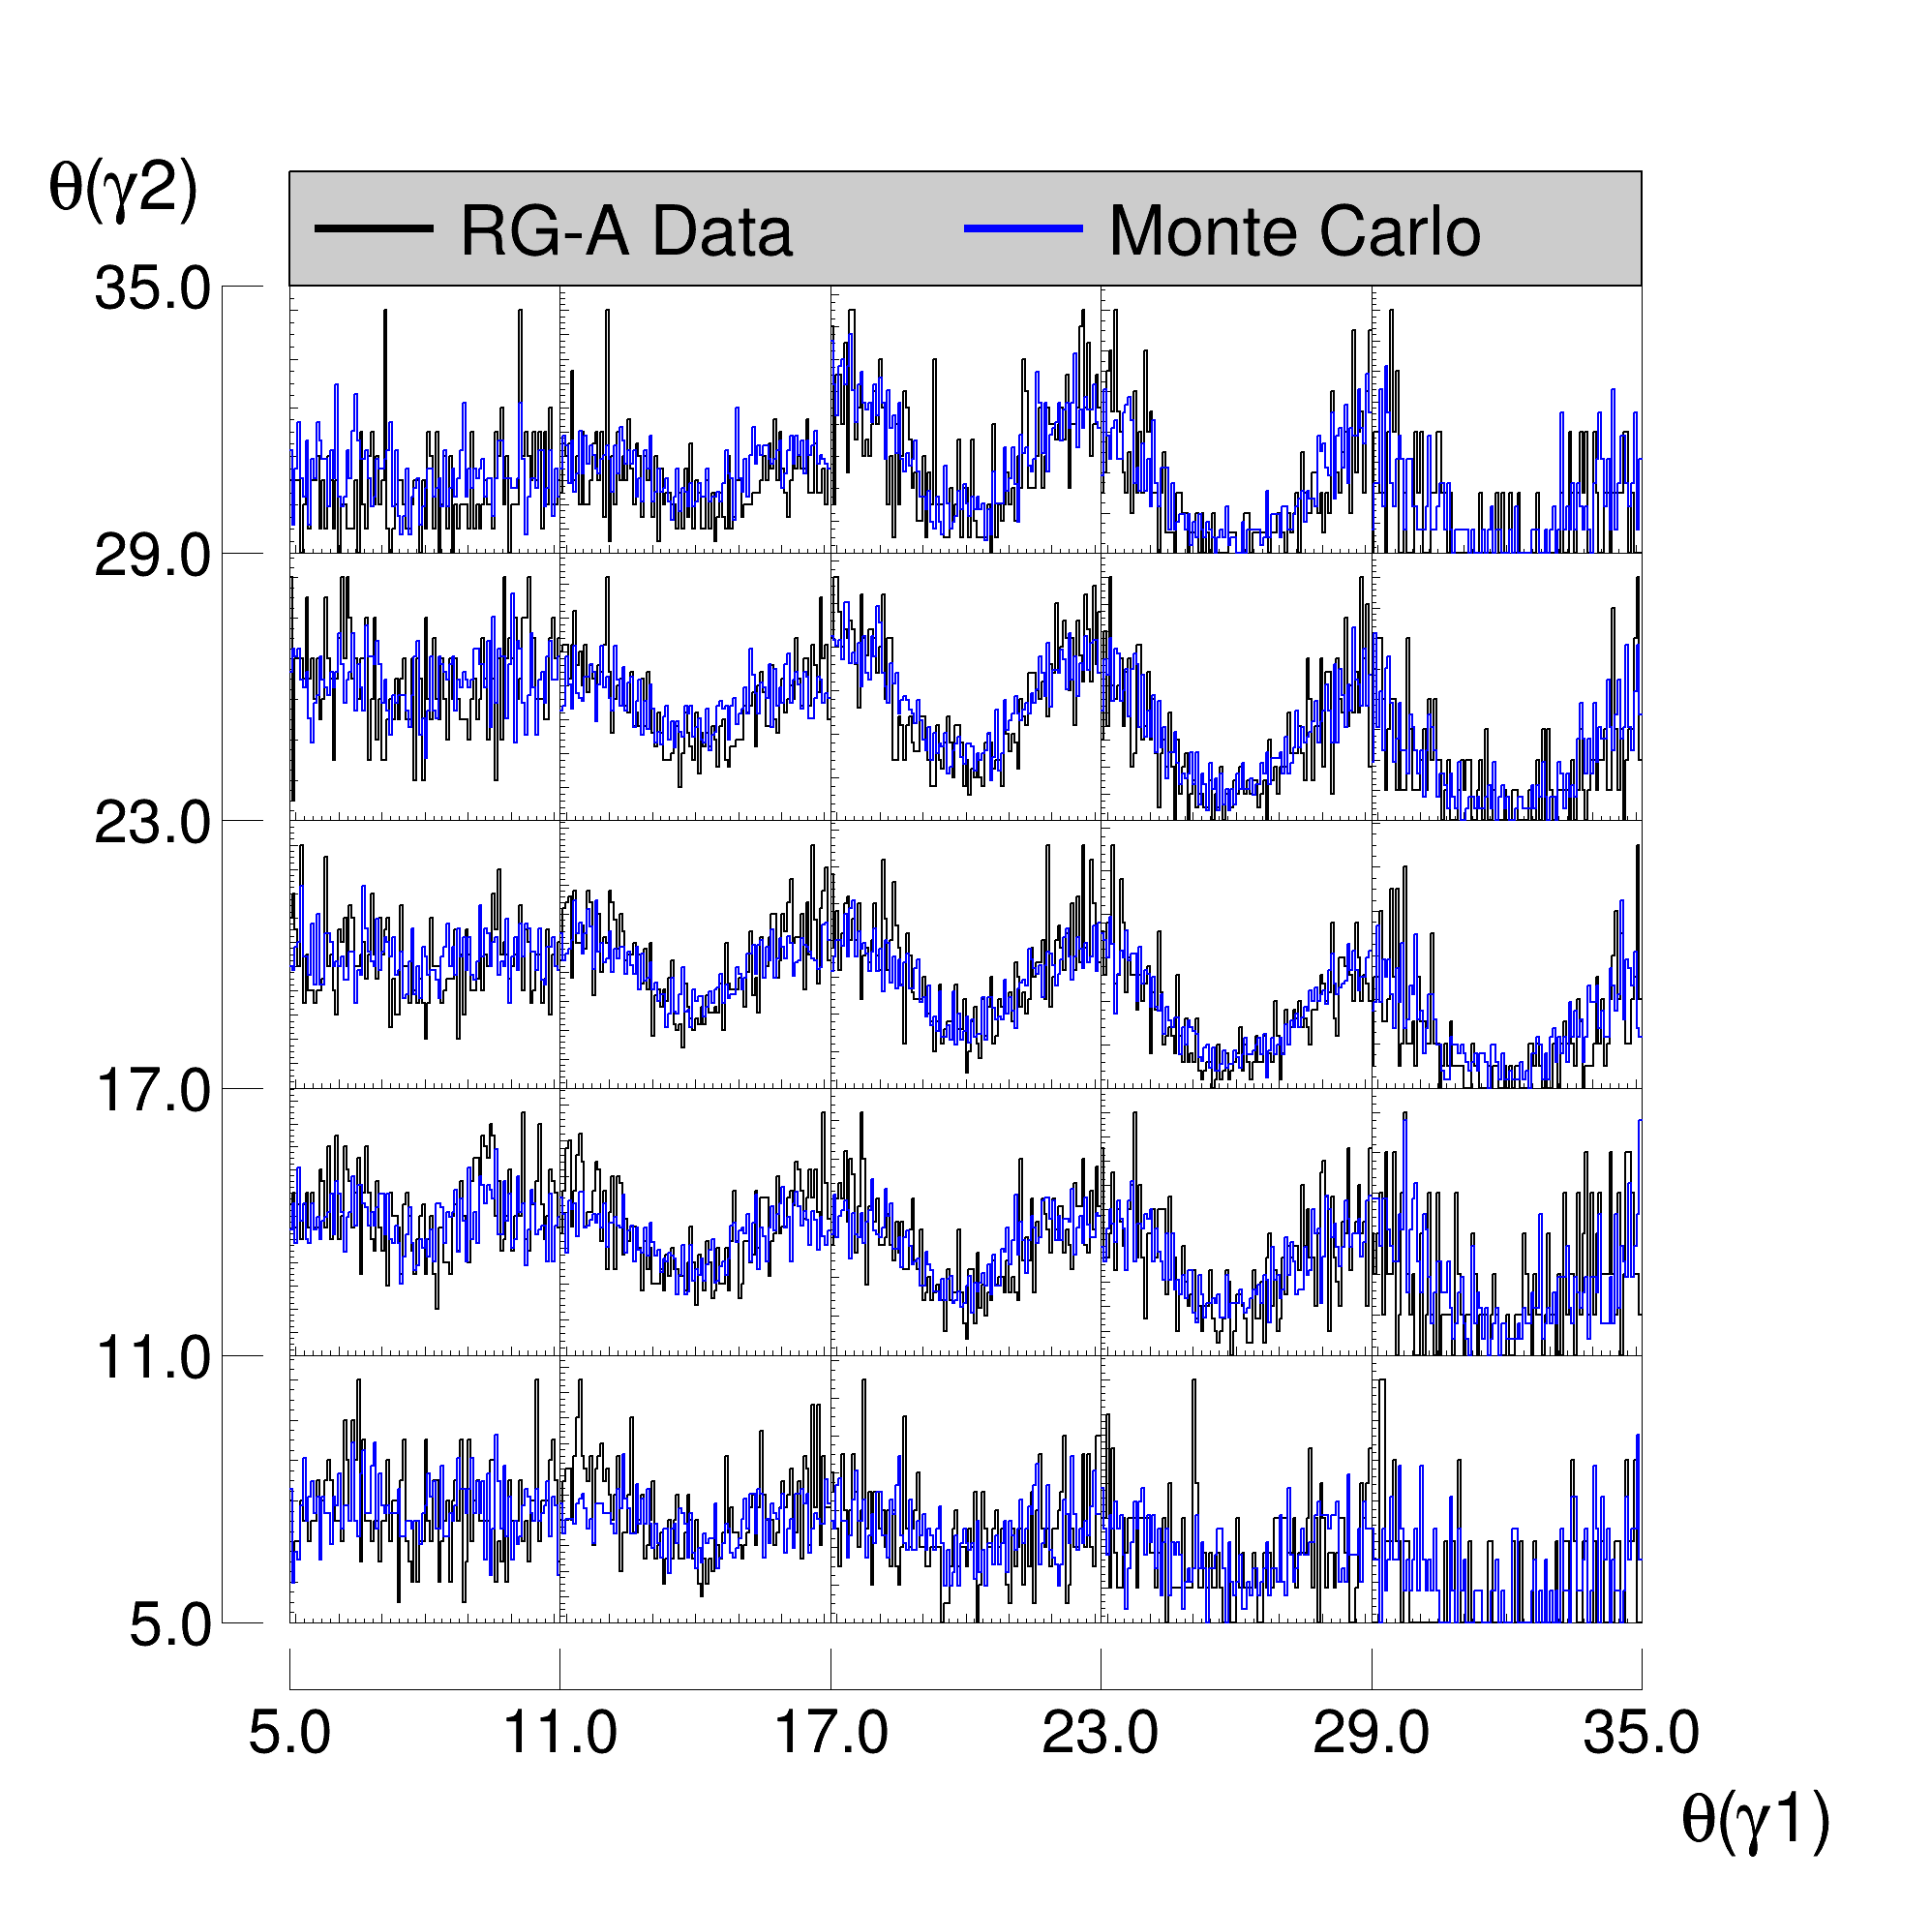

In [87]:
# Calculate number of bins
x_axis_nbins = len(x_axis_bins)-1
y_axis_nbins = len(y_axis_bins)-1

# Create a canvas
pad_size = 400
canvas = ROOT.TCanvas("canvas", "canvas", pad_size*x_axis_nbins, pad_size*y_axis_nbins)

hists_data = []
hists_mc = []
pads = []
# Loop over bins to create and draw histograms
for i in range(len(x_axis_bins) - 1):
    for j in tqdm(range(len(y_axis_bins) - 1)):
        # cd into the main TCanvas
        canvas.cd()
        # Define the cut for this pad
        cut = f"{x_axis_var} > {x_axis_bins[i]} && {x_axis_var} <= {x_axis_bins[i + 1]} && {y_axis_var} > {y_axis_bins[j]} && {y_axis_var} <= {y_axis_bins[j + 1]}"

        # Create a pad
        pad_name = f"pad_{i}_{j}"
        xlow = float(i) / (len(x_axis_bins) - 1) * 0.7 + 0.15
        ylow = float(j) / (len(y_axis_bins) - 1) * 0.7 + 0.15
        xup = float(i + 1) / (len(x_axis_bins) - 1) * 0.7 + 0.15
        yup = float(j + 1) / (len(y_axis_bins) - 1) * 0.7 + 0.15
        pads.append(ROOT.TPad(pad_name, "", xlow, ylow, xup, yup))
        pads[-1].SetMargin(0,0,0,0)  # Set margins to 0
        pads[-1].Draw()
        pads[-1].cd()

        # Create a histogram
        hist_data_name = f"hist_data_{i}_{j}"
        hist_mc_name = f"hist_mc_{i}_{j}"
        hists_data.append(ROOT.TH1F(hist_data_name, "", z_axis_nbins,z_axis_min, z_axis_max)) 
        hists_data[-1].SetLineColor(ROOT.kBlack)
        hists_data[-1].SetLineWidth(2)
        hists_mc.append(ROOT.TH1F(hist_mc_name, "", z_axis_nbins,z_axis_min, z_axis_max)) 
        hists_mc[-1].SetLineColor(ROOT.kBlue)
        hists_mc[-1].SetLineWidth(2)
        # Fill the histogram with the TTree data applying the cut
        tdata.Draw(f"{z_axis_var} >> {hist_data_name}", cut, "goff")
        tmc.Draw(f"{z_axis_var} >> {hist_mc_name}", cut, "goff")
        
        # Scale the Monte Carlo histogram to reflect data counts
        hists_mc[-1].Scale(1.0*nentries_data/nentries_mc)
        
        # Draw the histogram
        hists_data[-1].Draw("hist")
        hists_mc[-1].Draw("hist same")
        
        # Set the ymax 
        ymax = np.amax([hists_data[-1].GetMaximum(),hists_mc[-1].GetMaximum()])
        hists_data[-1].GetYaxis().SetRangeUser(0,ymax*1.1)
canvas.cd()

latex=ROOT.TLatex()
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatexNDC(0.87,0.035,x_axis_varname)
latex.DrawLatexNDC(0.025,0.89,y_axis_varname)

external_x_axis = ROOT.TGaxis(0.15,0.115,0.85,0.115, 0, x_axis_nbins, x_axis_nbins, "<")
external_x_axis.SetLabelSize(0.035)
external_x_axis.SetTitleSize(0.05)
external_x_axis.SetTitleOffset(0.72)
external_x_axis.SetLabelFont(42)
for i in range(x_axis_nbins + 1):
    external_x_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, str(x_axis_bins[i]))
external_x_axis.Draw("same")

external_y_axis = ROOT.TGaxis(0.115,0.15,0.115,0.85, 0, y_axis_nbins, y_axis_nbins, "<")
external_y_axis.SetLabelSize(0.035)
external_y_axis.SetTitleSize(0.05)
external_y_axis.SetTitleOffset(0.72)
external_y_axis.SetLabelFont(42)
for i in range(y_axis_nbins + 1):
    external_y_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, str(y_axis_bins[i]))
external_y_axis.Draw("same")

# Create the legend
legend = ROOT.TLegend(0.15,0.85,0.85,0.91)
legend.SetNColumns(2)
hdata = hists_data[-1].Clone()
hdata.SetLineWidth(8)
hmc = hists_mc[-1].Clone()
hmc.SetLineWidth(8)
legend.AddEntry(hdata,"RG-A Data","l")
legend.AddEntry(hmc,"Monte Carlo","l")

# Customize the legend box
legend.SetLineWidth(2)  # Increase border width
legend.SetFillColor(ROOT.kGray)  # Set fill color to grey
legend.SetFillStyle(1001)  # Solid fill

legend.Draw()
canvas.Draw()

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 361.65it/s]


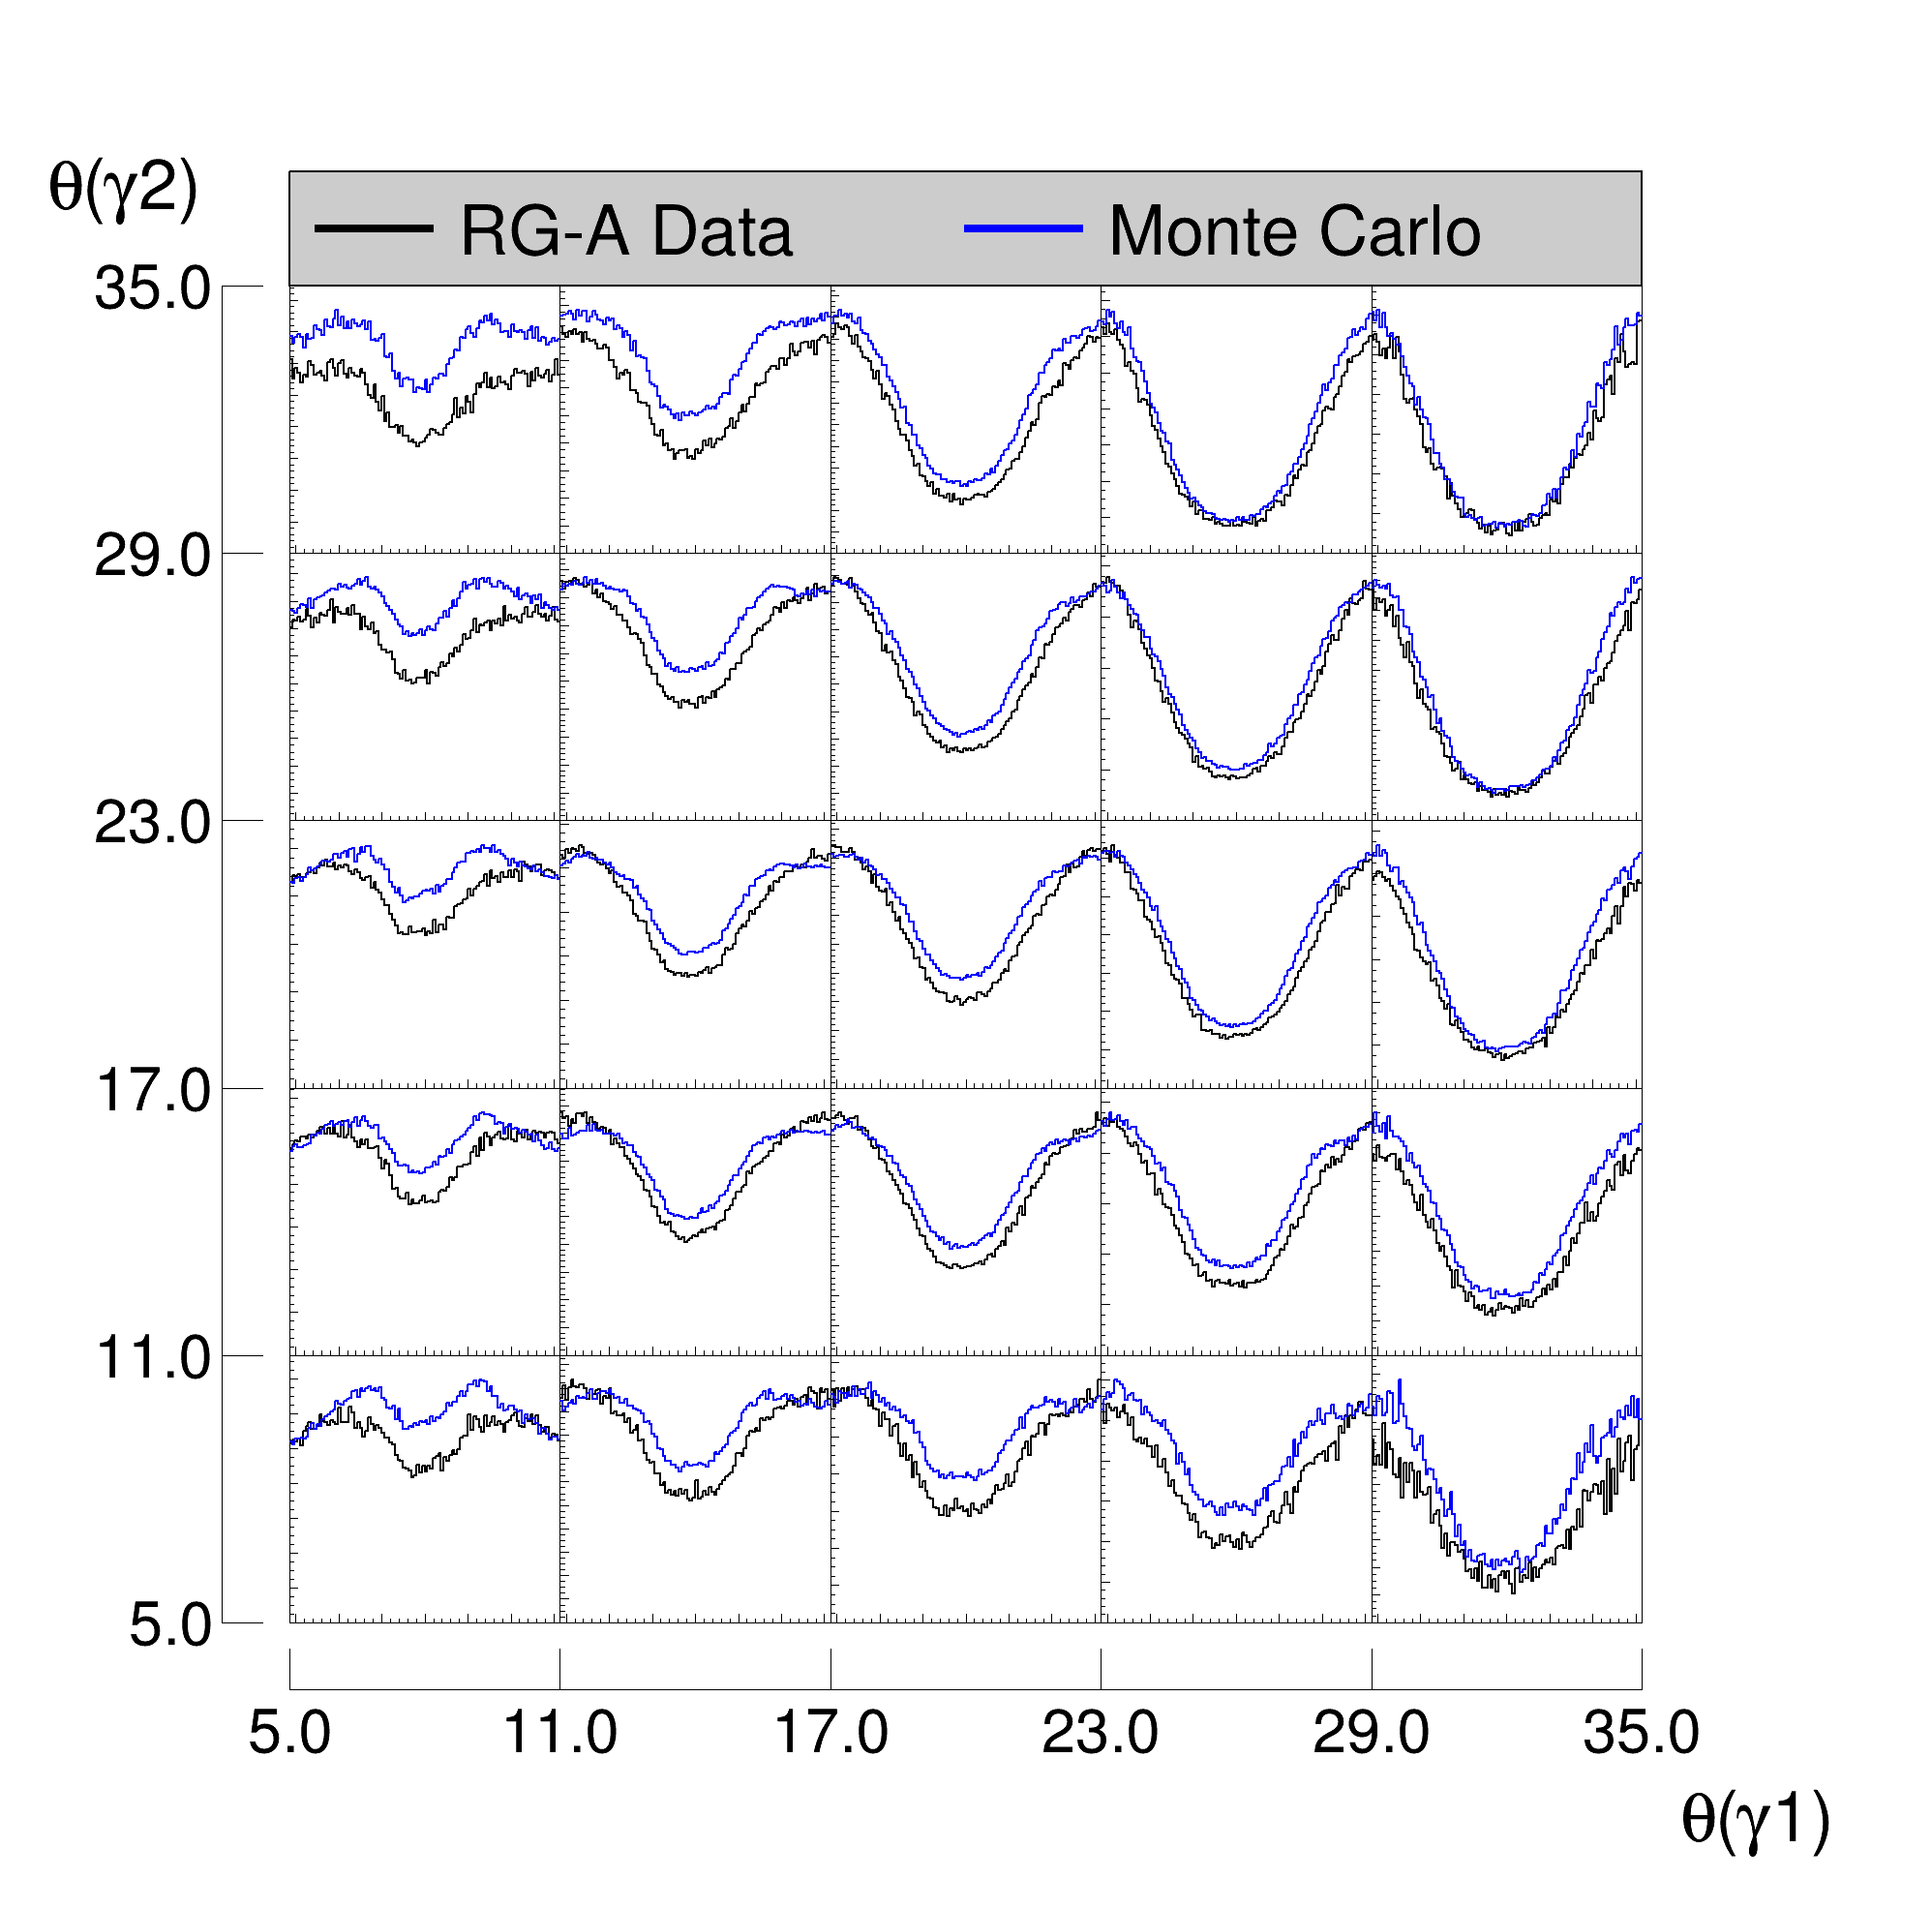

In [106]:
# Calculate number of bins
x_axis_nbins = len(x_axis_bins)-1
y_axis_nbins = len(y_axis_bins)-1

# Create a canvas
pad_size = 400
canvas = ROOT.TCanvas("canvas", "canvas", pad_size*x_axis_nbins, pad_size*y_axis_nbins)

# Load your dataframes
rdf_data = get_rdataframe([211,111],"data")
rdf_mc = get_rdataframe([211,111],"MC")

hists_data = []
hists_mc = []
pads = []

# Loop over bins to create and draw histograms
for i in range(len(x_axis_bins) - 1):
    for j in tqdm(range(len(y_axis_bins) - 1)):
        # cd into the main TCanvas
        canvas.cd()

        # Define the cut for this pad
        cut = f"{x_axis_var} > {x_axis_bins[i]} && {x_axis_var} <= {x_axis_bins[i + 1]} && {y_axis_var} > {y_axis_bins[j]} && {y_axis_var} <= {y_axis_bins[j + 1]}"

        # Create a pad
        pad_name = f"pad_{i}_{j}"
        xlow = float(i) / (len(x_axis_bins) - 1) * 0.7 + 0.15
        ylow = float(j) / (len(y_axis_bins) - 1) * 0.7 + 0.15
        xup = float(i + 1) / (len(x_axis_bins) - 1) * 0.7 + 0.15
        yup = float(j + 1) / (len(y_axis_bins) - 1) * 0.7 + 0.15
        pads.append(ROOT.TPad(pad_name, "", xlow, ylow, xup, yup))
        pads[-1].SetMargin(0,0,0,0)  # Set margins to 0
        pads[-1].Draw()
        pads[-1].cd()

        # Create a histogram
        hist_data_name = f"hist_data_{i}_{j}"
        hist_mc_name = f"hist_mc_{i}_{j}"
        hists_data.append(rdf_data.Filter(cut).Histo1D(ROOT.RDF.TH1DModel(hist_data_name, "", z_axis_nbins, z_axis_min, z_axis_max), z_axis_var))
        hists_mc.append(rdf_mc.Filter(cut).Histo1D(ROOT.RDF.TH1DModel(hist_mc_name, "", z_axis_nbins, z_axis_min, z_axis_max), z_axis_var))
        
count = 0         
for i in range(len(x_axis_bins) - 1):
    for j in range(len(y_axis_bins) - 1):
        pads[count].cd()
        # Scale the Monte Carlo histogram to reflect data counts
        hists_mc[count].Scale(1.0*nentries_data/nentries_mc)
        
        hists_data[count].Draw("hist")
        hists_mc[count].Draw("hist same")
        hists_data[count].SetLineColor(ROOT.kBlack)
        hists_data[count].SetLineWidth(2)
        hists_mc[count].SetLineColor(ROOT.kBlue)
        hists_mc[count].SetLineWidth(2)
        

        
        # Set the ymax 
        ymax = np.amax([hists_data[count].GetMaximum(),hists_mc[count].GetMaximum()])
        hists_data[count].GetYaxis().SetRangeUser(0,ymax*1.1)
        count+=1
        
canvas.cd()

latex=ROOT.TLatex()
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatexNDC(0.87,0.035,x_axis_varname)
latex.DrawLatexNDC(0.025,0.89,y_axis_varname)

external_x_axis = ROOT.TGaxis(0.15,0.115,0.85,0.115, 0, x_axis_nbins, x_axis_nbins, "<")
external_x_axis.SetLabelSize(0.035)
external_x_axis.SetTitleSize(0.05)
external_x_axis.SetTitleOffset(0.72)
external_x_axis.SetLabelFont(42)
for i in range(x_axis_nbins + 1):
    external_x_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, str(x_axis_bins[i]))
external_x_axis.Draw("same")

external_y_axis = ROOT.TGaxis(0.115,0.15,0.115,0.85, 0, y_axis_nbins, y_axis_nbins, "<")
external_y_axis.SetLabelSize(0.035)
external_y_axis.SetTitleSize(0.05)
external_y_axis.SetTitleOffset(0.72)
external_y_axis.SetLabelFont(42)
for i in range(y_axis_nbins + 1):
    external_y_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, str(y_axis_bins[i]))
external_y_axis.Draw("same")

# Create the legend
legend = ROOT.TLegend(0.15,0.85,0.85,0.91)
legend.SetNColumns(2)
hdata = hists_data[-1].Clone()
hdata.SetLineWidth(8)
hmc = hists_mc[-1].Clone()
hmc.SetLineWidth(8)
legend.AddEntry(hdata,"RG-A Data","l")
legend.AddEntry(hmc,"Monte Carlo","l")

# Customize the legend box
legend.SetLineWidth(2)  # Increase border width
legend.SetFillColor(ROOT.kGray)  # Set fill color to grey
legend.SetFillStyle(1001)  # Solid fill

legend.Draw()
canvas.Draw()

In [110]:
def create_2d_grid(x_axis_bins,x_axis_var,x_axis_varname,
                   y_axis_bins,y_axis_var,y_axis_varname,
                   z_axis_var, z_axis_min,z_axis_max,z_axis_nbins):
    # Calculate number of bins
    x_axis_nbins = len(x_axis_bins)-1
    y_axis_nbins = len(y_axis_bins)-1

    # Create a canvas
    pad_size = 400
    canvas = ROOT.TCanvas("canvas", "canvas", pad_size*x_axis_nbins, pad_size*y_axis_nbins)

    # Load your dataframes
    rdf_data = get_rdataframe([211,111],"data")
    rdf_mc = get_rdataframe([211,111],"MC")

    hists_data = []
    hists_mc = []
    pads = []

    # Loop over bins to create and draw histograms
    for i in range(len(x_axis_bins) - 1):
        for j in tqdm(range(len(y_axis_bins) - 1)):
            # cd into the main TCanvas
            canvas.cd()

            # Define the cut for this pad
            cut = f"{x_axis_var} > {x_axis_bins[i]} && {x_axis_var} <= {x_axis_bins[i + 1]} && {y_axis_var} > {y_axis_bins[j]} && {y_axis_var} <= {y_axis_bins[j + 1]}"

            # Create a pad
            pad_name = f"pad_{i}_{j}"
            xlow = float(i) / (len(x_axis_bins) - 1) * 0.7 + 0.15
            ylow = float(j) / (len(y_axis_bins) - 1) * 0.7 + 0.15
            xup = float(i + 1) / (len(x_axis_bins) - 1) * 0.7 + 0.15
            yup = float(j + 1) / (len(y_axis_bins) - 1) * 0.7 + 0.15
            pads.append(ROOT.TPad(pad_name, "", xlow, ylow, xup, yup))
            pads[-1].SetMargin(0,0,0,0)  # Set margins to 0
            pads[-1].Draw()
            pads[-1].cd()

            # Create a histogram
            hist_data_name = f"hist_data_{i}_{j}"
            hist_mc_name = f"hist_mc_{i}_{j}"
            hists_data.append(rdf_data.Filter(cut).Histo1D(ROOT.RDF.TH1DModel(hist_data_name, "", z_axis_nbins, z_axis_min, z_axis_max), z_axis_var))
            hists_mc.append(rdf_mc.Filter(cut).Histo1D(ROOT.RDF.TH1DModel(hist_mc_name, "", z_axis_nbins, z_axis_min, z_axis_max), z_axis_var))

    count = 0         
    for i in range(len(x_axis_bins) - 1):
        for j in range(len(y_axis_bins) - 1):
            pads[count].cd()
            # Scale the Monte Carlo histogram to reflect data counts
            hists_mc[count].Scale(1.0*nentries_data/nentries_mc)

            hists_data[count].Draw("hist")
            hists_mc[count].Draw("hist same")
            hists_data[count].SetLineColor(ROOT.kBlack)
            hists_data[count].SetLineWidth(2)
            hists_mc[count].SetLineColor(ROOT.kBlue)
            hists_mc[count].SetLineWidth(2)



            # Set the ymax 
            ymax = np.amax([hists_data[count].GetMaximum(),hists_mc[count].GetMaximum()])
            hists_data[count].GetYaxis().SetRangeUser(0,ymax*1.1)
            count+=1

    canvas.cd()

    latex=ROOT.TLatex()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatexNDC(0.87,0.035,x_axis_varname)
    latex.DrawLatexNDC(0.025,0.89,y_axis_varname)

    external_x_axis = ROOT.TGaxis(0.15,0.115,0.85,0.115, 0, x_axis_nbins, x_axis_nbins, "<")
    external_x_axis.SetLabelSize(0.035)
    external_x_axis.SetTitleSize(0.05)
    external_x_axis.SetTitleOffset(0.72)
    external_x_axis.SetLabelFont(42)
    for i in range(x_axis_nbins + 1):
        external_x_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, str(x_axis_bins[i]))
    external_x_axis.Draw("same")

    external_y_axis = ROOT.TGaxis(0.115,0.15,0.115,0.85, 0, y_axis_nbins, y_axis_nbins, "<")
    external_y_axis.SetLabelSize(0.035)
    external_y_axis.SetTitleSize(0.05)
    external_y_axis.SetTitleOffset(0.72)
    external_y_axis.SetLabelFont(42)
    for i in range(y_axis_nbins + 1):
        external_y_axis.ChangeLabel(i + 1, -1, -1, -1, -1, -1, str(y_axis_bins[i]))
    external_y_axis.Draw("same")

    # Create the legend
    legend = ROOT.TLegend(0.15,0.85,0.85,0.91)
    legend.SetNColumns(2)
    hdata = hists_data[-1].Clone()
    hdata.SetLineWidth(8)
    hmc = hists_mc[-1].Clone()
    hmc.SetLineWidth(8)
    legend.AddEntry(hdata,"RG-A Data","l")
    legend.AddEntry(hmc,"Monte Carlo","l")

    # Customize the legend box
    legend.SetLineWidth(2)  # Increase border width
    legend.SetFillColor(ROOT.kGray)  # Set fill color to grey
    legend.SetFillStyle(1001)  # Solid fill

    legend.Draw()
    return copy.deepcopy(canvas) 

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 538.59it/s]


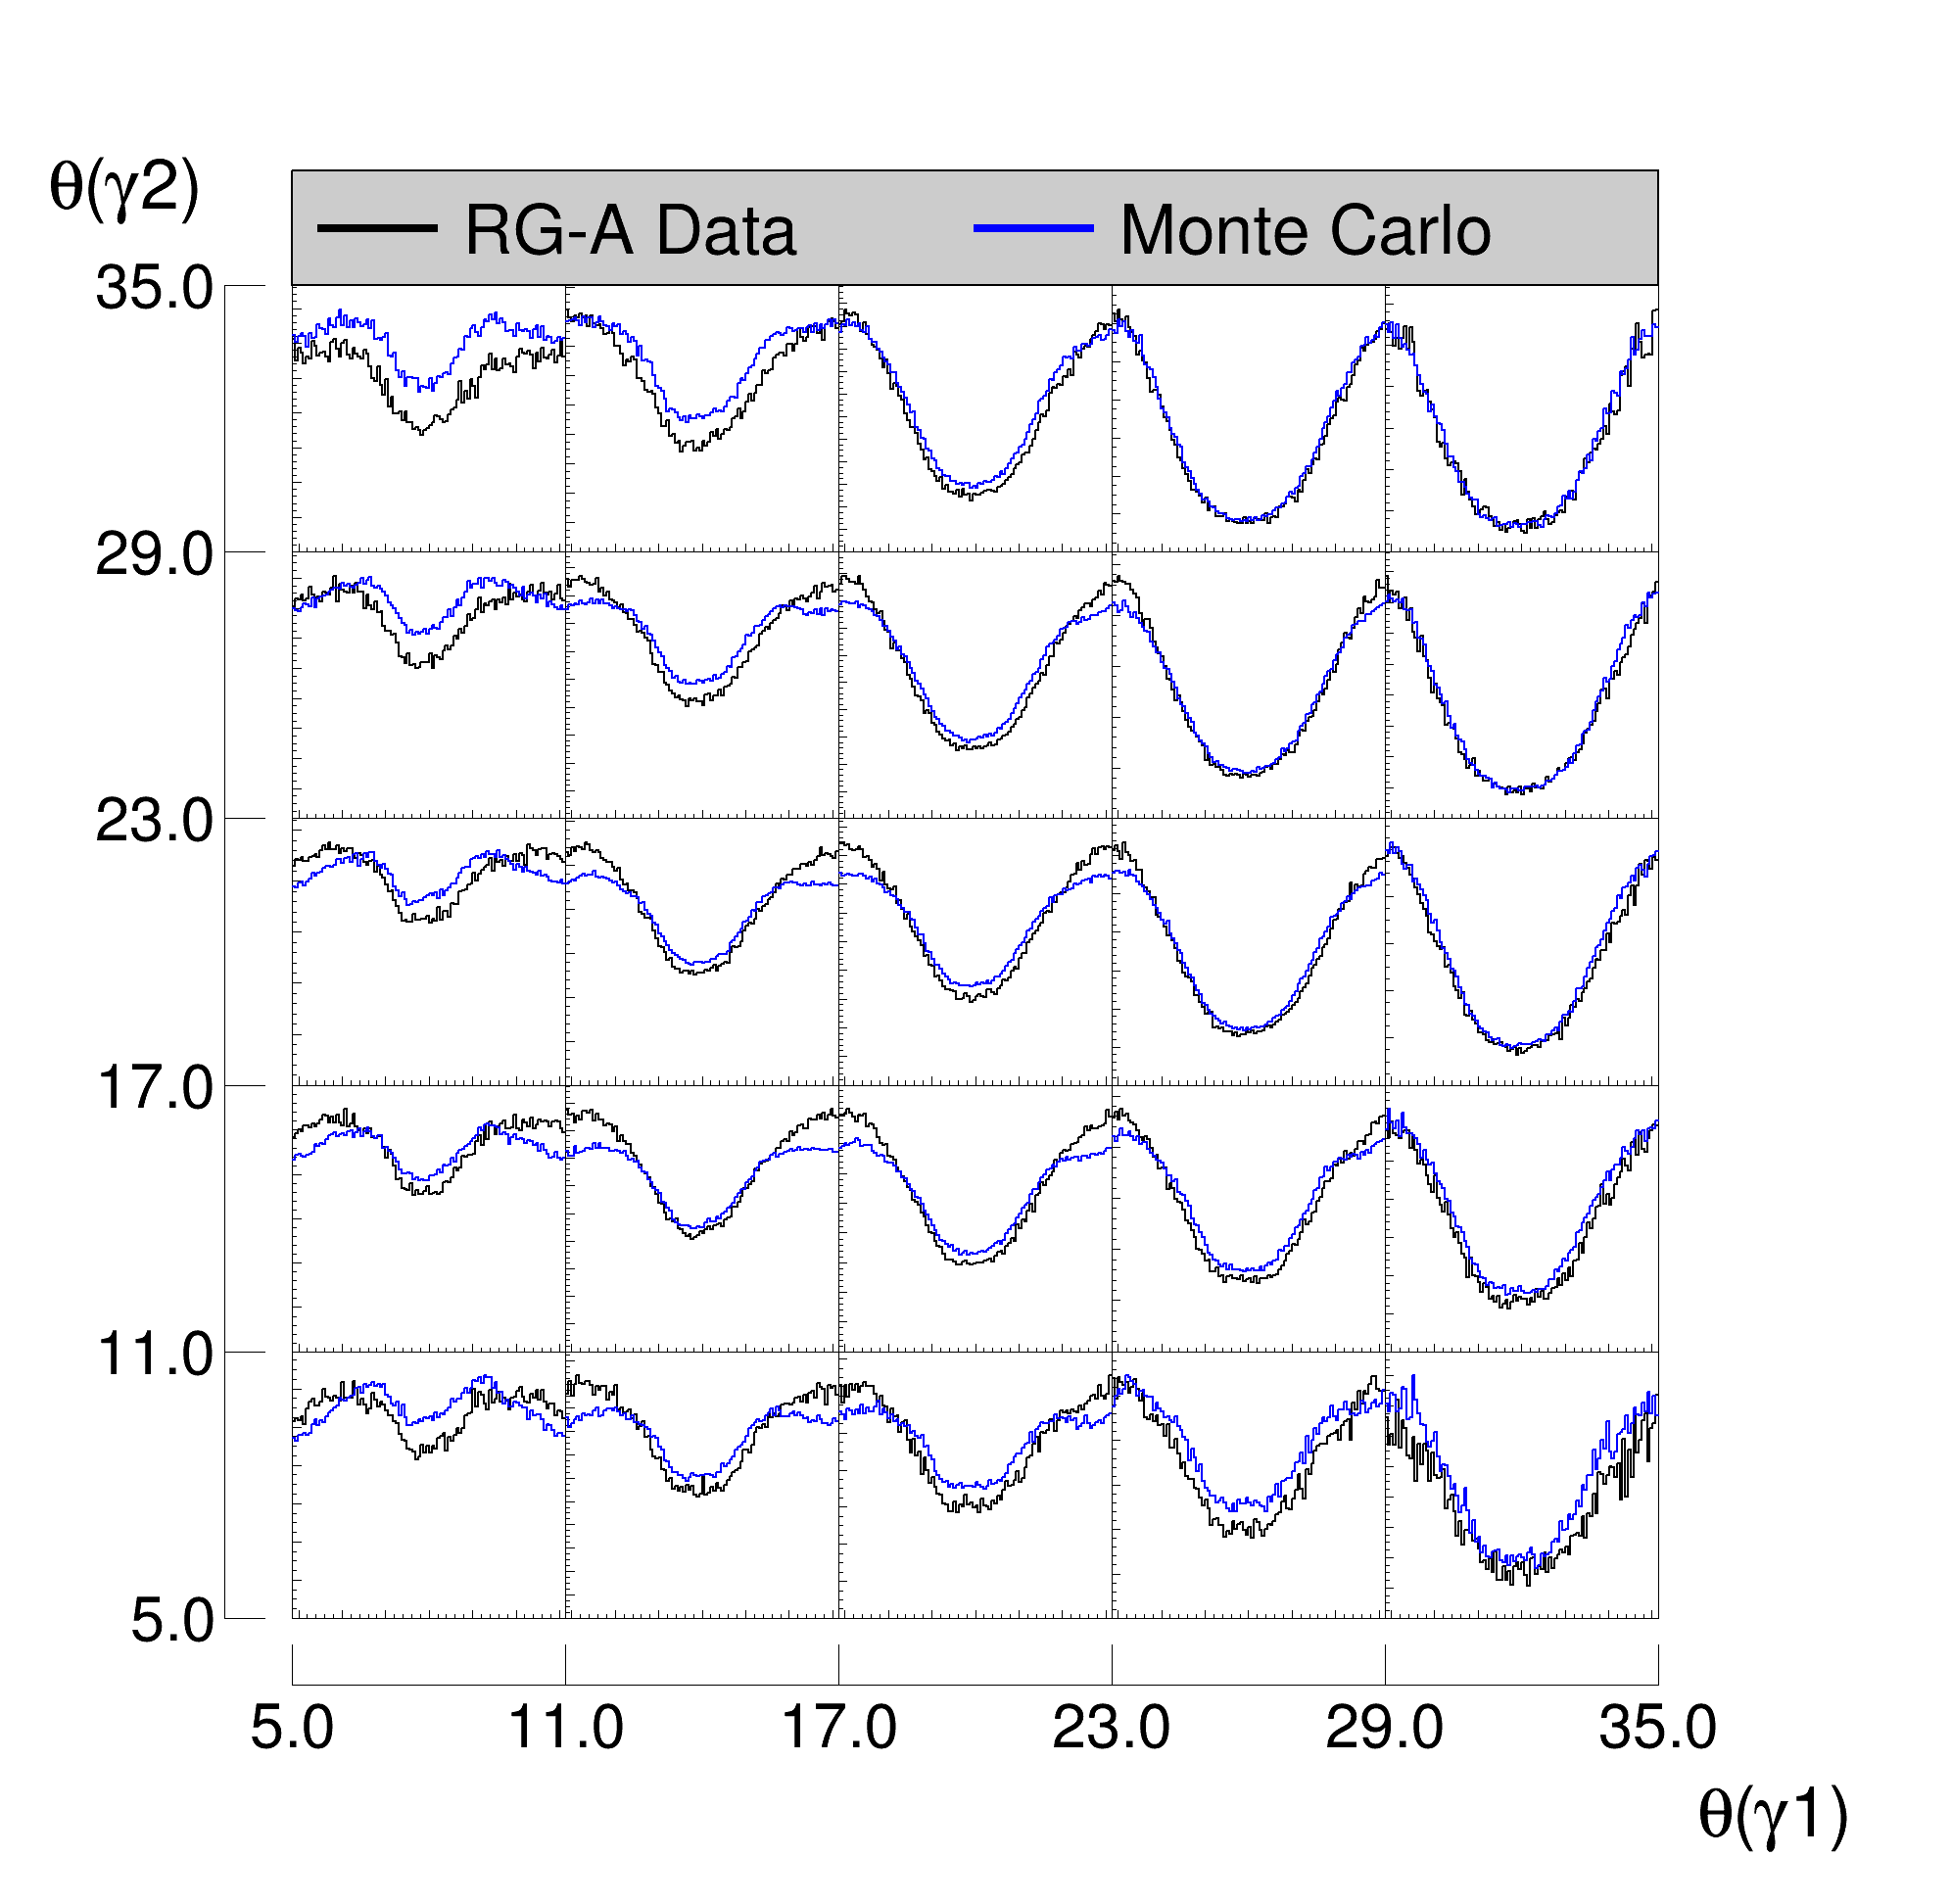

In [111]:
# Define your binning
x_axis_bins = np.linspace(5,35,6)
y_axis_bins = np.linspace(5,35,6)
x_axis_bins = array.array('d',np.round(x_axis_bins,3))
y_axis_bins = array.array('d',np.round(y_axis_bins,3))

x_axis_var = "th_21*180/3.1415"
y_axis_var = "th_22*180/3.1415"

x_axis_varname = "#theta(#gamma1)"
y_axis_varname = "#theta(#gamma2)"

z_axis_var = "phi_h"
z_axis_min = -3.1415
z_axis_max = 3.1415
z_axis_nbins = 100


canvas = create_2d_grid(x_axis_bins,x_axis_var,x_axis_varname,
                       y_axis_bins,y_axis_var,y_axis_varname,
                       z_axis_var, z_axis_min,z_axis_max,z_axis_nbins)

canvas.Draw()

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 370.57it/s]


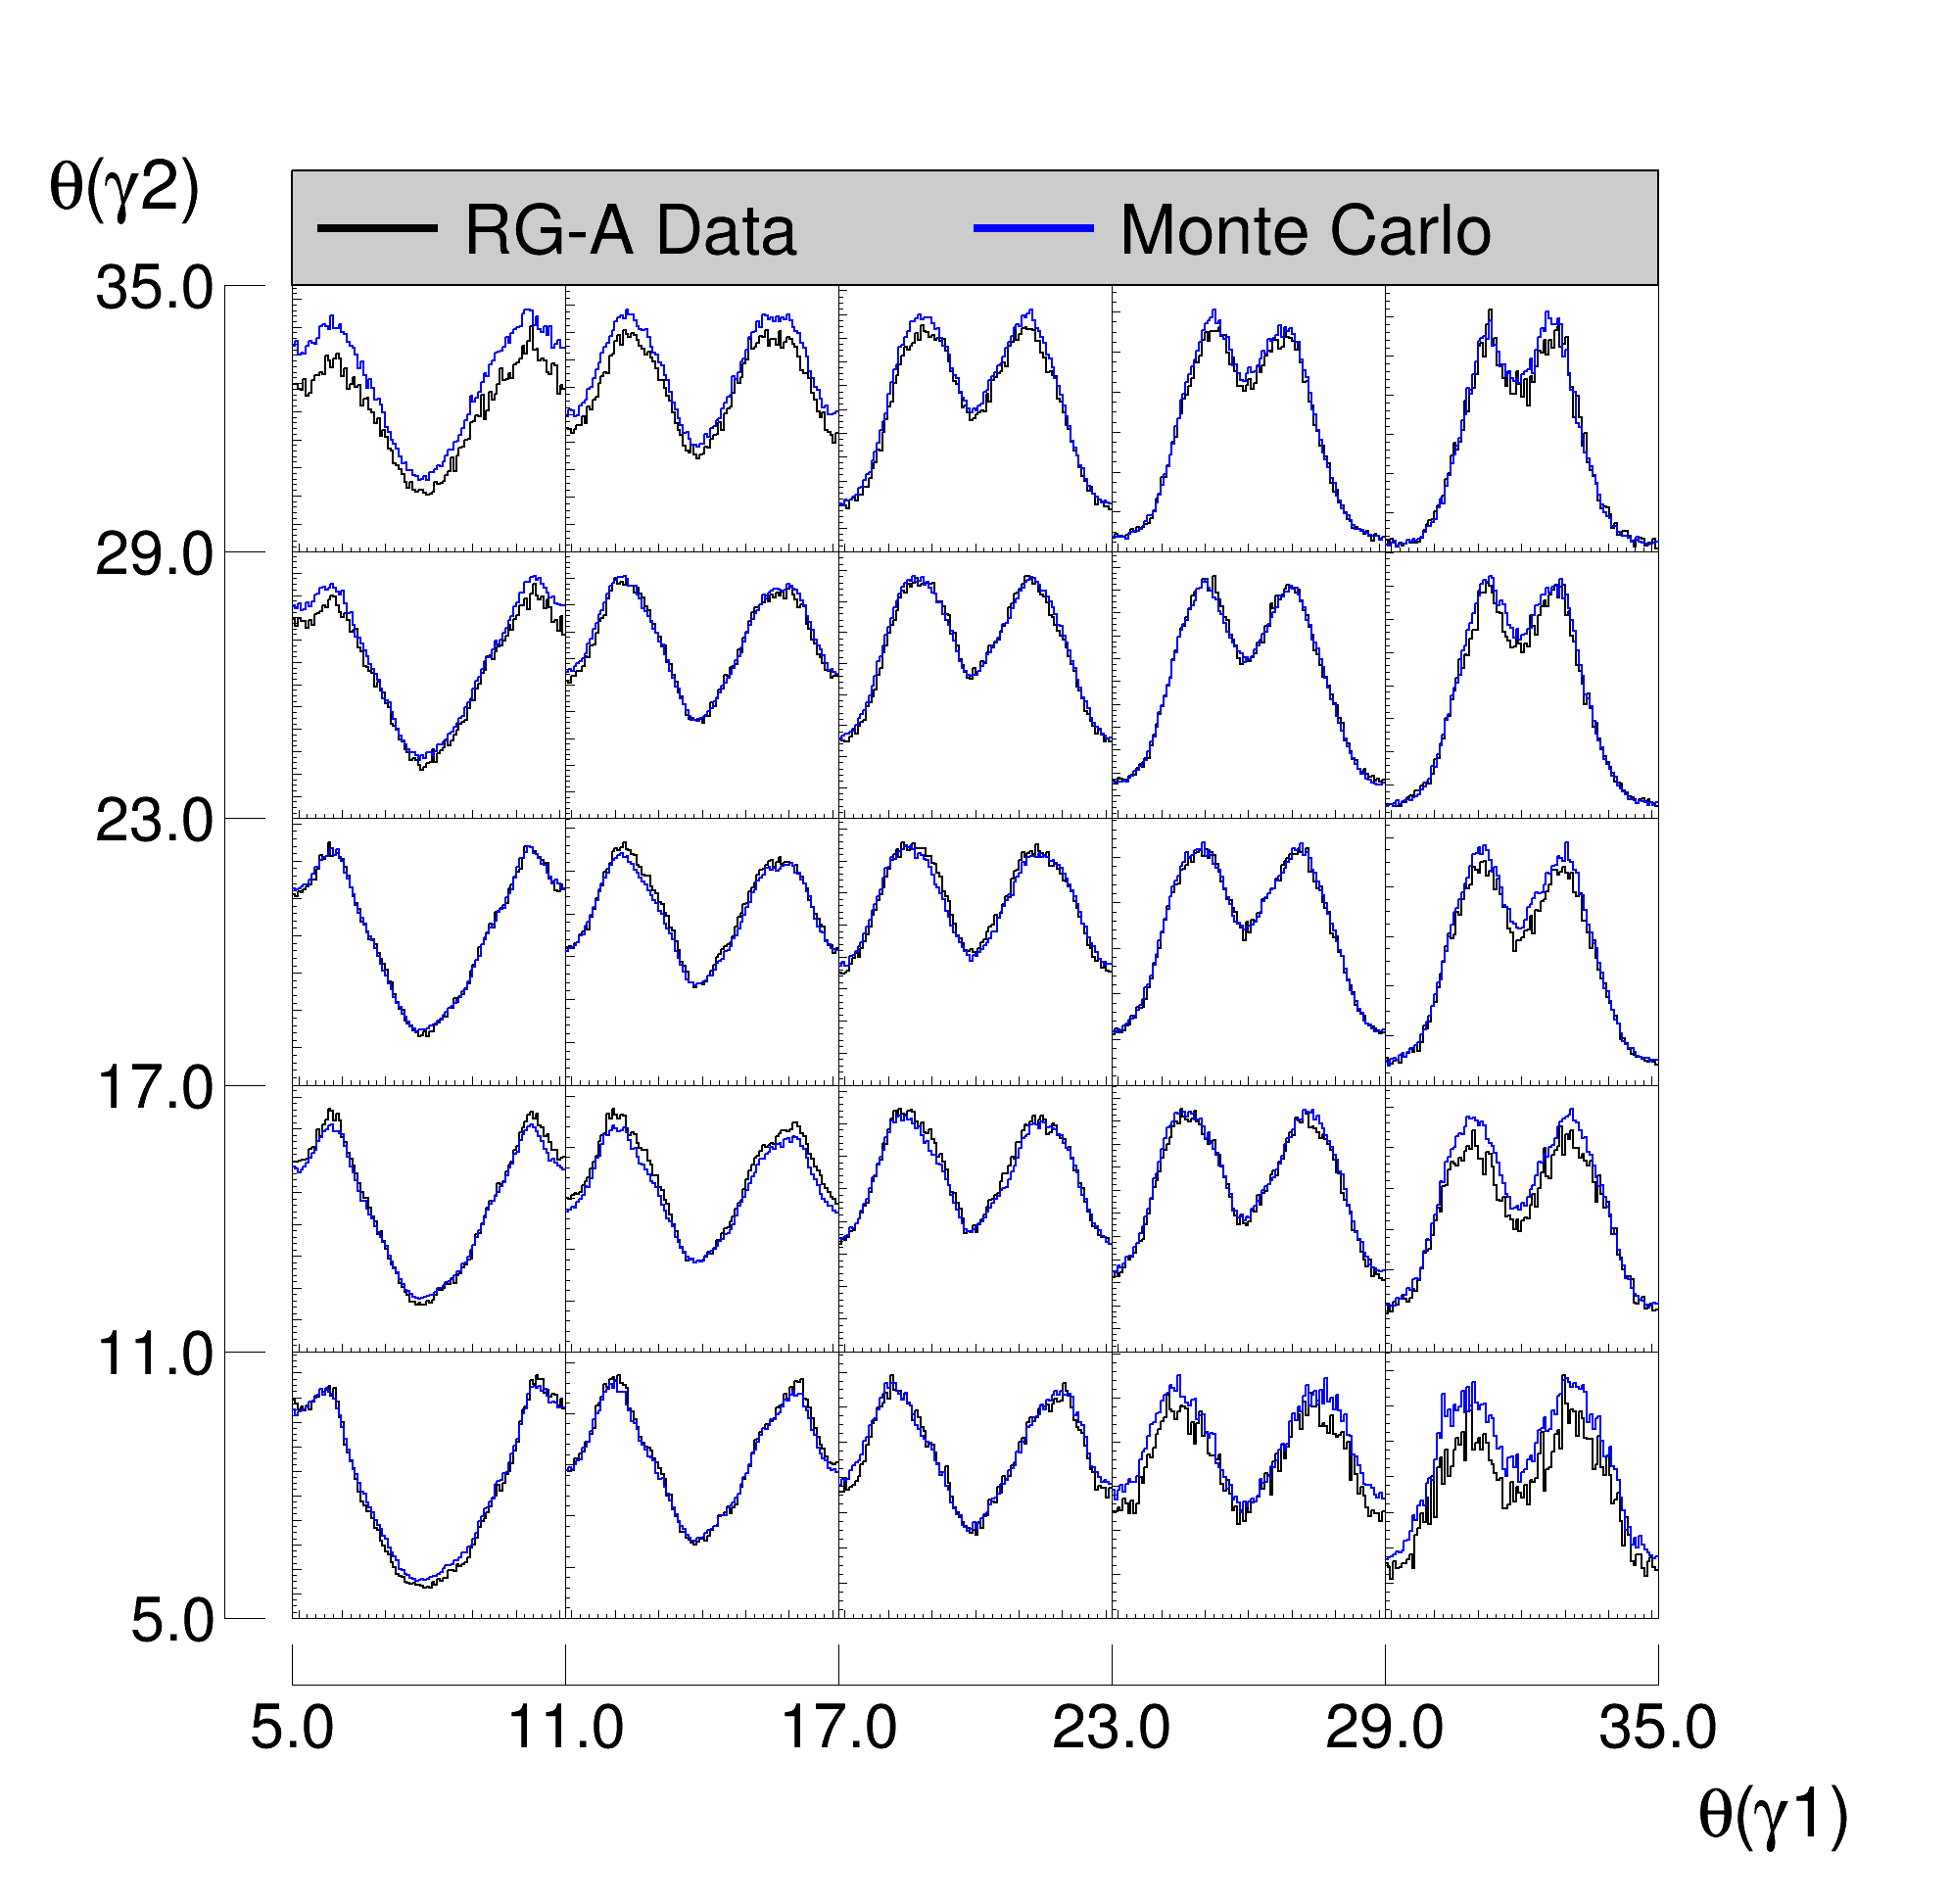

In [113]:
# Define your binning
x_axis_bins = np.linspace(5,35,6)
y_axis_bins = np.linspace(5,35,6)
x_axis_bins = array.array('d',np.round(x_axis_bins,3))
y_axis_bins = array.array('d',np.round(y_axis_bins,3))

x_axis_var = "th_21*180/3.1415"
y_axis_var = "th_22*180/3.1415"

x_axis_varname = "#theta(#gamma1)"
y_axis_varname = "#theta(#gamma2)"

z_axis_var = "phi_R0"
z_axis_min = -3.1415
z_axis_max = 3.1415
z_axis_nbins = 100


canvas = create_2d_grid(x_axis_bins,x_axis_var,x_axis_varname,
                       y_axis_bins,y_axis_var,y_axis_varname,
                       z_axis_var, z_axis_min,z_axis_max,z_axis_nbins)

canvas.Draw()